Import neccessary packages

In [77]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [78]:
import os
os.listdir("../input")

['plantdisease']

In [79]:
EPOCHS = 2
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((112, 112))
image_size = 0
directory_root = '../input/plantdisease/'
width=112
height=112
depth=3

Function to convert images to array

In [80]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [81]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


Get Size of Processed Image

In [82]:
image_size = len(image_list)

Transform Image Labels uisng Scikit LabelBinarizer

In [83]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

Print the classes

In [84]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [85]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [86]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [87]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [88]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 37, 37, 64)       

In [90]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [91]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/2
73/73 [==============================] - 86s 1s/step - loss: 0.2180 - acc: 0.9311 - val_loss: 0.4686 - val_acc: 0.8794
Epoch 2/2
73/73 [==============================] - 83s 1s/step - loss: 0.1538 - acc: 0.9474 - val_loss: 0.8451 - val_acc: 0.8759


Plot the train and val curve

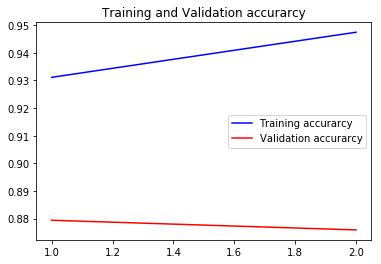

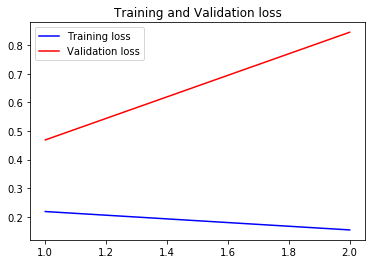

In [92]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [94]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
# print(model.predict(x_test[0],y_test[0]))
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 4s 6ms/sample - loss: 0.8460 - acc: 0.8759
Test Accuracy: 87.59164810180664


Save model using Pickle

In [97]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
